In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/state_dicts/

Gs_karras2019stylegan-bedrooms-256x256.pt
Gs_karras2019stylegan-ffhq-1024x1024.pt


In [ ]:
!cp -r /content/drive/MyDrive/state_dicts /content

In [ ]:
!cp -r /content/drive/MyDrive/catalogs  /content

In [ ]:
!git clone https://github.com/Shivani29sheth/DNN-Personification.git

Cloning into 'DNN-Personification'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 181 (delta 7), reused 159 (delta 0), pack-reused 0
Receiving objects: 100% (181/181), 30.15 MiB | 42.12 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
!mv DNN-Personification/* /content/

In [ ]:
%cd GAN\ Local\ Editing\ Reproduce

/content/GAN Local Editing Reproduce


In [ ]:
# import libraries
import torch
import stylegan                                     # StyleGAN model
from styleOP1 import Output              # Data structure to hold GAN outputs
import ptutils                                      # Helper tensor functions
import visutils                                     # Visualization functions
from factor_catalog import FactorCatalog            # Spherical k-means and the M matrix (Eq. 1)
from style_interpolator import StyleInterpolator    # The 'sequential' style-interpolator (Eq. 5)
import cielab     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
root_dir = '/content/state_dicts/'

dataset_name = 'FFHQ'
base_filename = 'ffhq-1024x1024'
truncation = 0.7

G = stylegan.StyleGAN.load_from_pth('{}/Gs_karras2019stylegan-{}.pt'.format(root_dir, base_filename)).eval()
G = G.cuda()
G.g_synthesis.set_noise(mode='fixed')

Load the pre-computed spherical k-means clusters, and provide them to the style interpolator

In [ ]:
catalog = torch.load('/content/catalogs/stylegan1_{}.pkl'.format(dataset_name))
si_wf = StyleInterpolator(catalog, bias=False)

Generate some examples

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


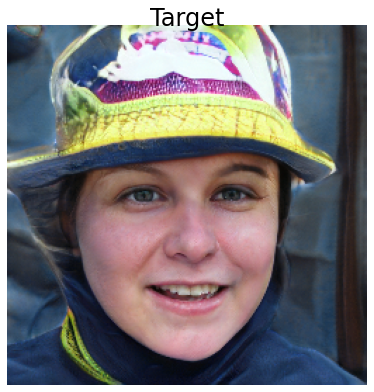

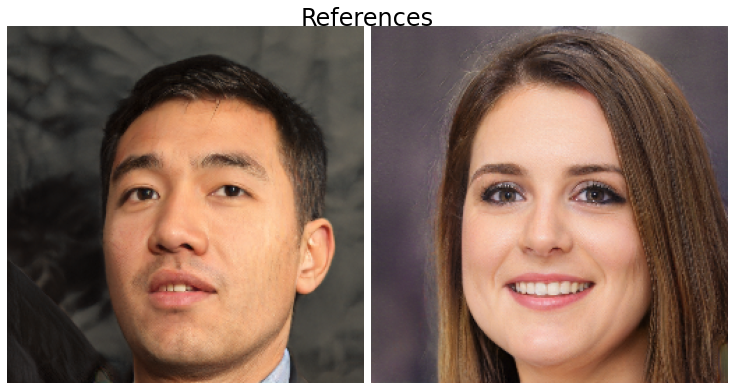

In [ ]:
# Target and reference images
gs = Output.from_seed(5, 97)

with torch.no_grad():
    
    gs.ys = G.z_to_ys(gs.z.cuda(), truncation=truncation)
    rgb = G.ys_to_rgb(gs.ys)
    rgb = (rgb.clamp(-1, 1) + 1) / 2
    rgb = rgb.cpu()
    gs.rgb = ptutils.MultiResolutionStore(rgb)
        
    gs1 = gs[:1]
    gs2 = gs[1:3]

res=256
i, n = 0,4
visutils.show(gs1.rgb.get(res)[i:i+n].permute(0,2,3,1).cpu(), title='Target')
visutils.show(gs2.rgb.get(res)[i:i+n].permute(0,2,3,1).cpu(), title='References')

In [ ]:
type(gs1)

styleOP1.Output

Transfer object styles from refernces to target 

In [ ]:
# Single style transfer using feature clusters
part_gs = {}

def get_epsilons(epsilon, low_res_epsilon=0):
    epsilons = [epsilon]*len(G.AdaIN_layers)
    for i in range(4): epsilons[i] = low_res_epsilon
    return epsilons

parts_thresholds = {
        'eyes': (0.1, get_epsilons(50, 5)),
        'nose': (0.1, get_epsilons(30, 5)),
        'mouth': (0.1, get_epsilons(50, 5)),
    }

for label, (rho, epsilon) in parts_thresholds.items():
        key = (label)
        part_gs[key]  = Output()
        part_gs[key].ys = si_wf.interpolate_ys(gs1.ys, gs2.ys, label, rho, epsilon)
        with torch.no_grad():
                rgb = G.ys_to_rgb(part_gs[key].ys)
                rgb = (rgb.clamp(-1, 1) + 1) / 2
                rgb = rgb.cpu()
                part_gs[key].rgb = ptutils.MultiResolutionStore(rgb)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


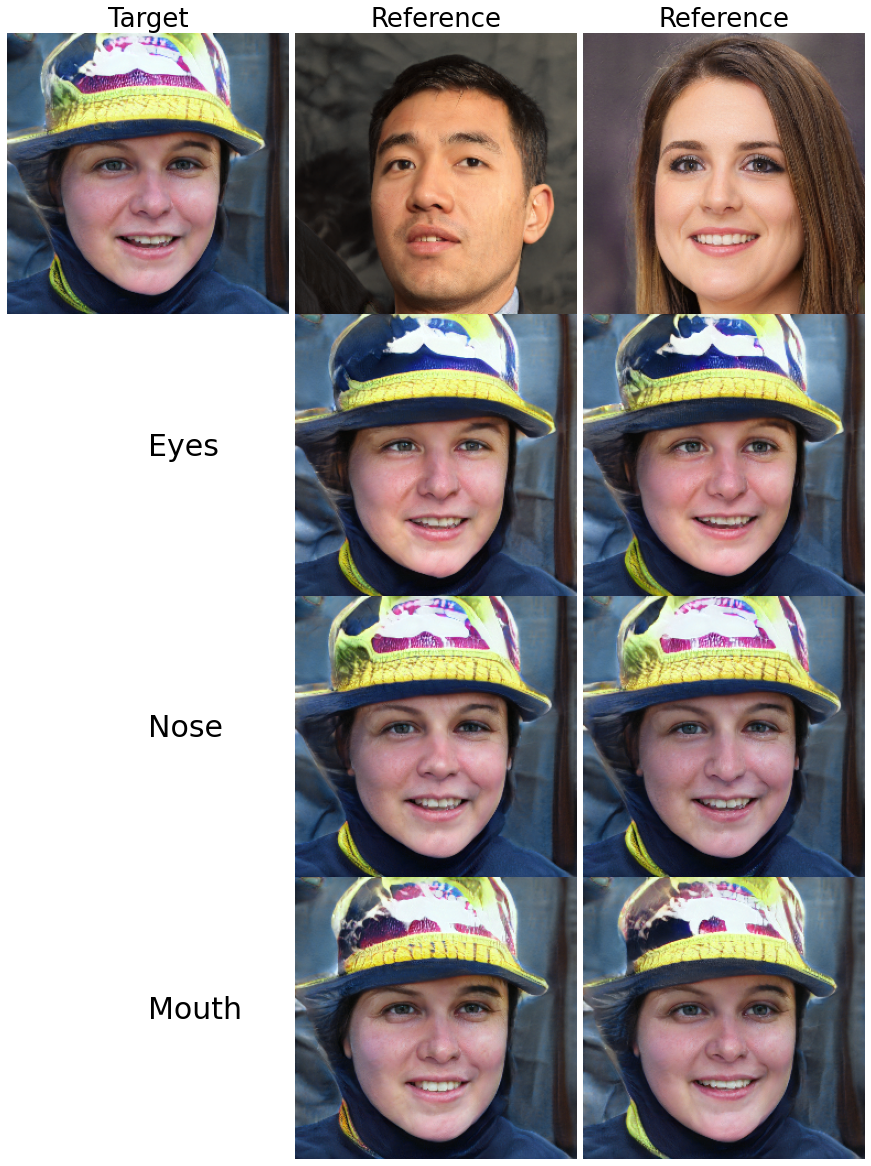

In [ ]:
res = 256
visutils.part_grid(gs1.rgb.get(res), gs2.rgb.get(res), {k: v.rgb.get(res) for k,v in part_gs.items()});

In [ ]:
# Multiple style transfer
part_gs = {}

def get_epsilons(epsilon, low_res_epsilon=0):
    epsilons = [epsilon]*len(G.AdaIN_layers)
    for i in range(4): epsilons[i] = low_res_epsilon
    return epsilons

parts_thresholds = {
        'eyes': (0.01, get_epsilons(50, 5)),
        'nose': (0.05, get_epsilons(30, 5)),
        'mouth': (0.01, get_epsilons(50, 5)),
    }
for label, (rho, epsilon) in parts_thresholds.items():
        key = (label)
        part_gs[key]  = Output()
        part_gs[key].ys = si_wf.interpolate_ys(gs1.ys, gs2.ys, label, rho, epsilon)
        with torch.no_grad():
                rgb = G.ys_to_rgb(part_gs[key].ys)
                rgb = (rgb.clamp(-1, 1) + 1) / 2
                rgb = rgb.cpu()
                part_gs[key].rgb = ptutils.MultiResolutionStore(rgb)
                gs1 = part_gs[key]

View the results

In [ ]:
gs1 = gs[:1]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


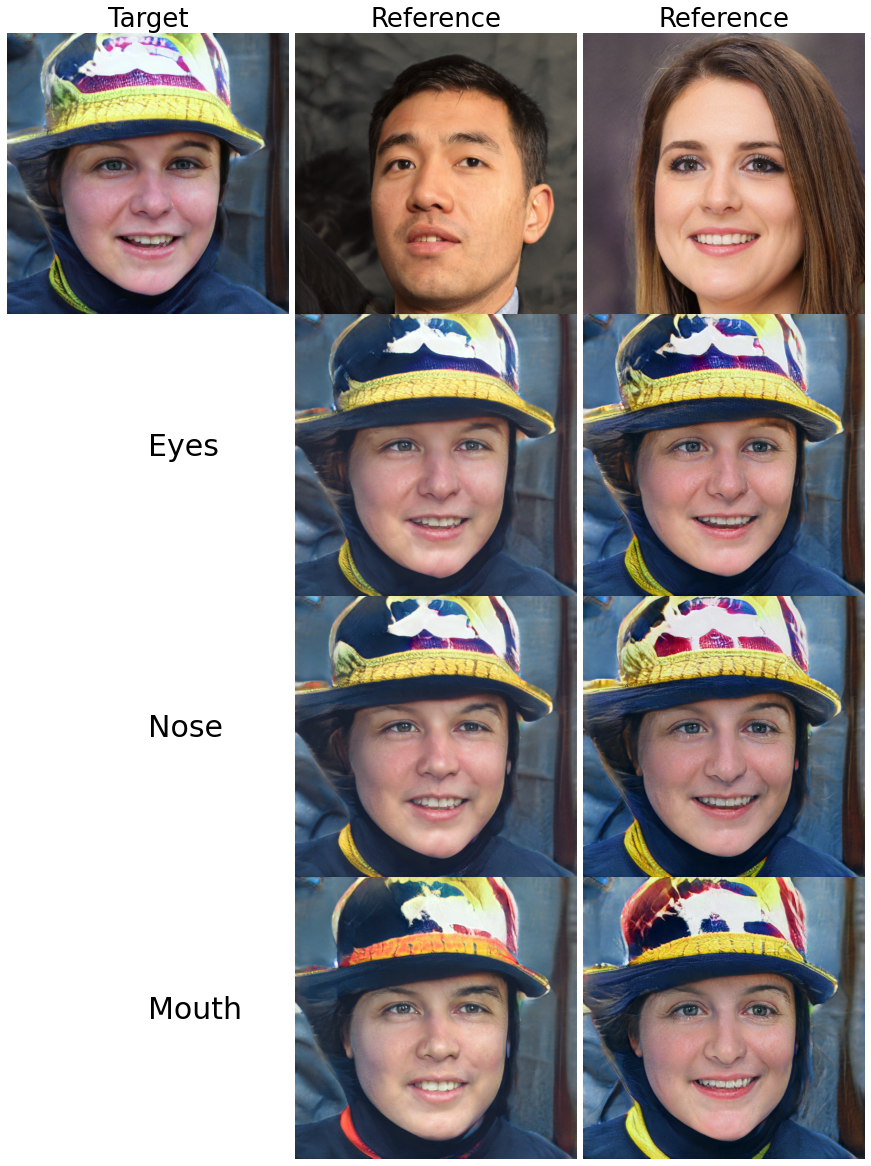

In [ ]:
res = 1080
visutils.part_grid(gs1.rgb.get(res), gs2.rgb.get(res), {k: v.rgb.get(res) for k,v in part_gs.items()});